## calculating ID using gpt-2 model for a sample text

In [6]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import re

# Initialize the Hugging Face pipeline for text generation
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # Replace with a different model if needed
model = AutoModelForCausalLM.from_pretrained("gpt2")
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Function to preprocess the text (split into sentences and tokenize)
def preprocess_text(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return sentences

# Function to call the Hugging Face model and classify ideas in the text
def classify_ideas(sentence):
    prompt = "Analyze for idea density:\n\"{}\"\nList only:\n1. Predications\n2. Modifications\n3. Connections\nBe concise."
    
    response = text_generator(prompt, max_length=150, num_return_sequences=1)
    return response[0]['generated_text']

# Function to count ideas from the model response
def count_ideas(classified_ideas):
    ideas = classified_ideas.split("\n")
    return len(ideas)

# Function to calculate idea density
def calculate_idea_density(text):
    sentences = preprocess_text(text)
    total_ideas = 0
    total_words = len(text.split())  # Total word count in the text
    
    for sentence in sentences:
        classified_ideas = classify_ideas(sentence)
        idea_count = count_ideas(classified_ideas)
        total_ideas += idea_count
        
    idea_density = (total_ideas / total_words) * 10  # Ideas per 10 words
    return idea_density

# Example usage
sample_text = """
Nowadays, a hot and essential controversy centering on the concerns whether Network real-name system.
A fair proportion of people contend that the network have to use the real name, other people, nevertheless,
advocate that network not necessary use you real name. As far as I am concerned, I side with the latter. 
Of the countless reasons or facts that strengthen my viewpoint, I will present the most consequential and conspicuous ones here.

"""
idea_density = calculate_idea_density(sample_text)
print(f"Idea Density: {idea_density}")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Idea Density: 4.027777777777778


## Generating a usable dataset from Distinct XML files from fce-released-dataset

In [ ]:
import xml.etree.ElementTree as ET
import csv
import os

def safe_find(element, path):
    found = element.find(path)
    return found.text if found is not None else "N/A"

def parse_xml_file(file_path):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()

        head = root.find(".//head")
        sortkey = head.get("sortkey") if head is not None else "N/A"
        
        candidate = root.find(".//candidate")
        if candidate is None:
            return None  # Skip this file if there's no candidate data

        extracted_data = {
            "file_name": os.path.basename(file_path),
            "sortkey": sortkey,
            "language": safe_find(candidate, "personnel/language"),
            "age": safe_find(candidate, "personnel/age"),
            "overall_score": safe_find(candidate, "score"),
            "answers": []
        }

        answers = root.findall(".//answer1") + root.findall(".//answer2")

        for answer in answers:
            question_number = safe_find(answer, "question_number")
            exam_score = safe_find(answer, "exam_score")
            
            coded_answer = answer.find("coded_answer")
            answer_text = "".join(coded_answer.itertext()).strip() if coded_answer is not None else "N/A"

            extracted_data["answers"].append({
                "question_number": question_number,
                "exam_score": exam_score,
                "answer_text": answer_text
            })

        return extracted_data
    except ET.ParseError:
        print(f"Error parsing file: {file_path}")
        return None

def process_multiple_files(directory_path, output_csv_path):
    all_data = []

    # Process all XML files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".xml"):
            file_path = os.path.join(directory_path, filename)
            data = parse_xml_file(file_path)
            if data is not None:
                all_data.append(data)

    # Write data to CSV
    with open(output_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['File Name', 'Sort Key', 'Language', 'Age', 'Overall Score', 
                      'Question Number', 'Exam Score', 'Answer Text']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        for data in all_data:
            for answer in data['answers']:
                writer.writerow({
                    'File Name': data['file_name'],
                    'Sort Key': data['sortkey'],
                    'Language': data['language'],
                    'Age': data['age'],
                    'Overall Score': data['overall_score'],
                    'Question Number': answer['question_number'],
                    'Exam Score': answer['exam_score'],
                    'Answer Text': answer['answer_text']
                })

# Example usage
directory_path = "fce-released-dataset/dataset/Data"  # Path to your XML files
output_csv_path = "learners_data.csv"  # The output CSV file name

process_multiple_files(directory_path, output_csv_path)
print(f"Data from all XML files has been extracted and saved to {output_csv_path}")

## Analysis of Dataset generated

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def parse_exam_score(score):
    if pd.isna(score):
        return None
    if isinstance(score, (int, float)):
        return float(score)
    if isinstance(score, str):
        # Extract all numeric values from the string
        numbers = re.findall(r'\d+\.\d+|\d+', score)
        if numbers:
            # Convert to floats and return the average
            return sum(float(num) for num in numbers) / len(numbers)
    return None

# Load the CSV file into a DataFrame
csv_file_path = "learners_data.csv"
df = pd.read_csv(csv_file_path)

# Convert 'Overall Score' to numeric, replacing non-convertible values with NaN
df['Overall Score'] = pd.to_numeric(df['Overall Score'], errors='coerce')

# Parse the 'Exam Score' values
df['Parsed Exam Score'] = df['Exam Score'].apply(parse_exam_score)

# Display basic information about the DataFrame
print(df.info())

# Display the first few rows of the DataFrame
print("\nFirst few rows of the data:")
print(df.head())

# Display summary statistics of numerical columns
print("\nSummary statistics of numerical columns:")
print(df.describe())

# Count the number of unique learners (assuming each file represents a unique learner)
unique_learners = df['File Name'].nunique()
print(f"\nNumber of unique learners: {unique_learners}")

# Calculate average scores
average_overall_score = df['Overall Score'].mean()
average_exam_score = df['Parsed Exam Score'].mean()
print(f"\nAverage Overall Score: {average_overall_score:.2f}")
print(f"Average Parsed Exam Score: {average_exam_score:.2f}")

# Distribution of languages
language_distribution = df['Language'].value_counts()
print("\nDistribution of languages:")
print(language_distribution)

# Visualize language distribution
plt.figure(figsize=(10, 6))
language_distribution.plot(kind='bar')
plt.title('Distribution of Languages')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('language_distribution.png')
plt.close()

# Visualize the relationship between Overall Score and Parsed Exam Score
plt.figure(figsize=(10, 6))
plt.scatter(df['Overall Score'], df['Parsed Exam Score'])
plt.title('Overall Score vs Parsed Exam Score')
plt.xlabel('Overall Score')
plt.ylabel('Parsed Exam Score')
plt.savefig('score_relationship.png')
plt.close()

print("\nAnalysis complete. Check the current directory for generated visualizations.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   File Name          2481 non-null   object 
 1   Sort Key           2481 non-null   object 
 2   Language           2481 non-null   object 
 3   Age                2467 non-null   object 
 4   Overall Score      2481 non-null   float64
 5   Question Number    2481 non-null   object 
 6   Exam Score         2473 non-null   object 
 7   Answer Text        2481 non-null   object 
 8   Parsed Exam Score  2469 non-null   float64
dtypes: float64(2), object(7)
memory usage: 174.6+ KB
None

First few rows of the data:
     File Name          Sort Key Language    Age  Overall Score  \
0   doc100.xml  TR2*0102*2000*01   Korean  26-30           29.0   
1   doc100.xml  TR2*0102*2000*01   Korean  26-30           29.0   
2  doc1000.xml  TR3*0100*2000*02  Catalan  16-20           28.0   
3  doc1000

## Additional insights

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load the CSV file
df = pd.read_csv("learners_data.csv")

# Data Preprocessing
def parse_exam_score(score):
    if pd.isna(score):
        return None
    if isinstance(score, (int, float)):
        return float(score)
    if isinstance(score, str):
        numbers = re.findall(r'\d+\.\d+|\d+', score)
        if numbers:
            return sum(float(num) for num in numbers) / len(numbers)
    return None

df['Parsed Exam Score'] = df['Exam Score'].apply(parse_exam_score)
df['Overall Score'] = pd.to_numeric(df['Overall Score'], errors='coerce')

# Basic Statistics
print("Basic Statistics:")
print(df.describe())

# Language Distribution
plt.figure(figsize=(12, 6))
df['Language'].value_counts().plot(kind='bar')
plt.title('Distribution of Languages')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('language_distribution.png')
plt.close()

# Age Distribution
plt.figure(figsize=(10, 6))
df['Age'].value_counts().plot(kind='bar')
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('age_distribution.png')
plt.close()

# Score Distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Overall Score'].dropna(), kde=True)
plt.title('Distribution of Overall Scores')
plt.subplot(1, 2, 2)
sns.histplot(df['Parsed Exam Score'].dropna(), kde=True)
plt.title('Distribution of Exam Scores')
plt.tight_layout()
plt.savefig('score_distributions.png')
plt.close()

# Correlation between Overall Score and Exam Score
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Overall Score', y='Parsed Exam Score', data=df)
plt.title('Overall Score vs Exam Score')
plt.tight_layout()
plt.savefig('score_correlation.png')
plt.close()

# Performance by Language
plt.figure(figsize=(12, 6))
sns.boxplot(x='Language', y='Overall Score', data=df)
plt.title('Overall Score Distribution by Language')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('score_by_language.png')
plt.close()

# Performance by Age Group
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age', y='Overall Score', data=df)
plt.title('Overall Score Distribution by Age Group')
plt.tight_layout()
plt.savefig('score_by_age.png')
plt.close()

# Text Analysis
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.isalnum() and word not in stop_words]

all_words = []
for text in df['Answer Text']:
    all_words.extend(preprocess_text(text))

word_freq = Counter(all_words)

# Word Cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Answers')
plt.tight_layout()
plt.savefig('word_cloud.png')
plt.close()

# Average Answer Length
df['Answer Length'] = df['Answer Text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
plt.figure(figsize=(10, 6))
sns.histplot(df['Answer Length'], kde=True)
plt.title('Distribution of Answer Lengths')
plt.xlabel('Number of Words')
plt.tight_layout()
plt.savefig('answer_length_distribution.png')
plt.close()

# Correlation between Answer Length and Scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Answer Length', y='Overall Score', data=df)
plt.title('Answer Length vs Overall Score')
plt.subplot(1, 2, 2)
sns.scatterplot(x='Answer Length', y='Parsed Exam Score', data=df)
plt.title('Answer Length vs Exam Score')
plt.tight_layout()
plt.savefig('answer_length_vs_scores.png')
plt.close()

print("Analysis complete. Check the current directory for generated visualizations.")

# Additional insights
print("\nAdditional Insights:")
print(f"Total number of learners: {df['File Name'].nunique()}")
print(f"Average Overall Score: {df['Overall Score'].mean():.2f}")
print(f"Average Exam Score: {df['Parsed Exam Score'].mean():.2f}")
print(f"Most common language: {df['Language'].mode().values[0]}")
print(f"Most common age group: {df['Age'].mode().values[0]}")
print(f"Average answer length: {df['Answer Length'].mean():.2f} words")
print("\nTop 10 most common words in answers:")
print(word_freq.most_common(10))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AMAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AMAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Basic Statistics:
       Overall Score  Parsed Exam Score
count    2481.000000        2469.000000
mean       27.871826           3.506723
std         5.489331           0.975072
min         0.000000           0.000000
25%        24.000000           3.100000
50%        28.000000           3.300000
75%        32.000000           4.200000
max        40.000000           5.300000
Analysis complete. Check the current directory for generated visualizations.

Additional Insights:
Total number of learners: 1244
Average Overall Score: 27.87
Average Exam Score: 3.51
Most common language: Spanish
Most common age group: 16-20
Average answer length: 198.17 words

Top 10 most common words in answers:
[('would', 3219), ('like', 2836), ('show', 2031), ('time', 1697), ('people', 1659), ('could', 1505), ('dear', 1420), ('think', 1381), ('good', 1321), ('go', 1273)]


## Generating the ID for whole Dataset

In [2]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import csv
import re
import torch

# Initialize the Hugging Face pipeline for text generation
model_name = "gpt2"  # You can change this to a different model if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Use GPU if available
device = 0 if torch.cuda.is_available() else -1
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device=device)

def preprocess_text(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return sentences

def classify_ideas(sentence):
    prompt = "Analyze for idea density:\n\"{}\"\nList only:\n1. Predications\n2. Modifications\n3. Connections\nBe concise."
    
    response = text_generator(prompt, max_new_tokens=100, num_return_sequences=1, do_sample=True, temperature=0.7, top_p=0.9)
    return response[0]['generated_text']

def count_ideas(classified_ideas):
    # Split the ideas, ignoring the prompt repetition
    ideas = classified_ideas.split("\n")[1:]  # Skip the first line (prompt)
    # Count non-empty lines
    return sum(1 for idea in ideas if idea.strip())

def calculate_idea_density(text):
    sentences = preprocess_text(text)
    total_ideas = 0
    total_words = len(text.split())  # Total word count in the text
    
    for sentence in sentences:
        classified_ideas = classify_ideas(sentence)
        idea_count = count_ideas(classified_ideas)
        total_ideas += idea_count
        
    idea_density = (total_ideas / total_words) * 10  # Ideas per 10 words
    return round(idea_density, 2)

def process_csv_file(input_csv_path, output_csv_path):
    with open(input_csv_path, 'r', newline='', encoding='utf-8') as infile, \
         open(output_csv_path, 'w', newline='', encoding='utf-8') as outfile:
        
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames + ['Idea Density']
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        
        writer.writeheader()
        for row in reader:
            answer_text = row['Answer Text']
            idea_density = calculate_idea_density(answer_text)
            row['Idea Density'] = idea_density
            writer.writerow(row)
    print(f"Idea density calculations complete. Results saved to {output_csv_path}")

# Usage
input_csv_path = "learners_data.csv"  # Path to your existing CSV file
output_csv_path = "learners_data_with_idea_density.csv"  # Path for the new CSV file with idea density
process_csv_file(input_csv_path, output_csv_path)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Idea density calculations complete. Results saved to learners_data_with_idea_density.csv


## Analysis of Idea density against other columns


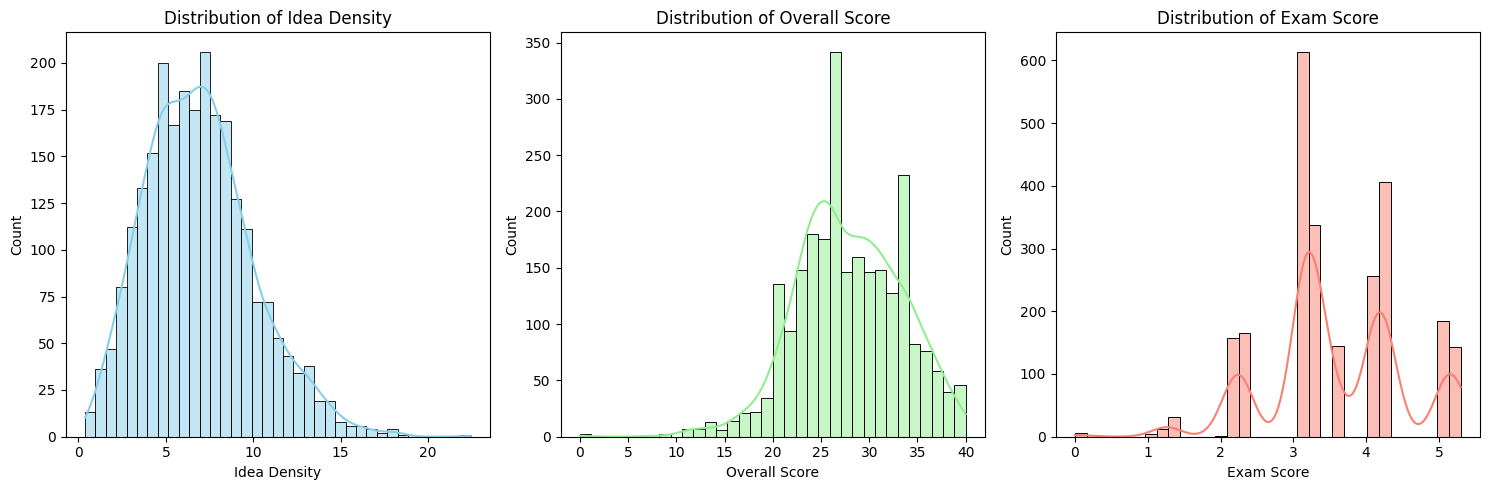

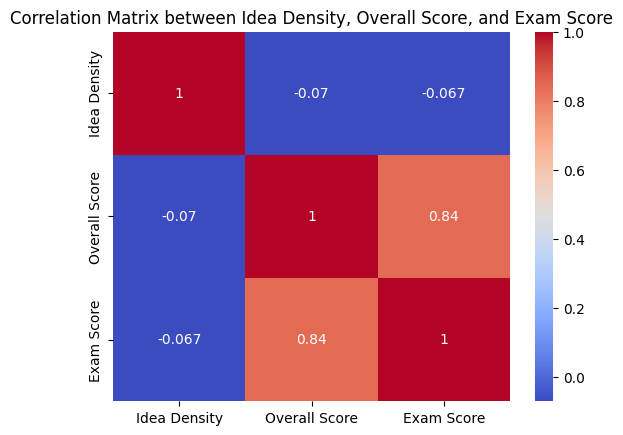

C:\Users\AMAN\AppData\Local\Temp\ipykernel_7552\491691779.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Language', y='Idea Density', data=data, palette='Set2')
C:\Users\AMAN\AppData\Local\Temp\ipykernel_7552\491691779.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Age', y='Idea Density', data=data, palette='Set3')


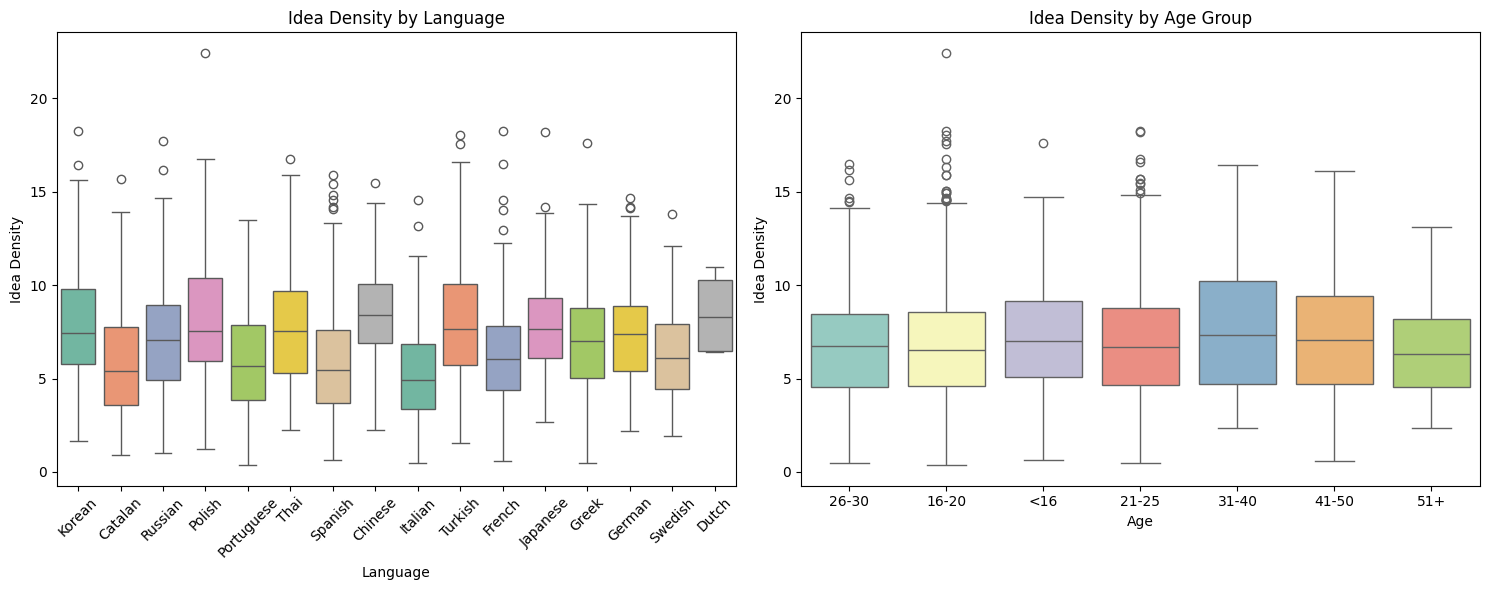

Regression Analysis: Idea Density vs Overall Score
                            OLS Regression Results                            
Dep. Variable:           Idea Density   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     12.15
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           0.000499
Time:                        14:23:42   Log-Likelihood:                -6273.1
No. Observations:                2467   AIC:                         1.255e+04
Df Residuals:                    2465   BIC:                         1.256e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'learners_data_with_idea_density.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Step 1: Data Cleaning
# Convert 'Exam Score' to numeric and handle missing values
data['Exam Score'] = pd.to_numeric(data['Exam Score'], errors='coerce')
data['Exam Score'].fillna(data['Exam Score'].mean(), inplace=True)

# Drop rows with missing 'Age' as it's a categorical column
data.dropna(subset=['Age'], inplace=True)

# Step 2: Exploratory Data Analysis (EDA)
# Plot distributions of Idea Density, Overall Score, and Exam Score
plt.figure(figsize=(15, 5))

# Idea Density Distribution
plt.subplot(1, 3, 1)
sns.histplot(data['Idea Density'], kde=True, color='skyblue')
plt.title('Distribution of Idea Density')

# Overall Score Distribution
plt.subplot(1, 3, 2)
sns.histplot(data['Overall Score'], kde=True, color='lightgreen')
plt.title('Distribution of Overall Score')

# Exam Score Distribution
plt.subplot(1, 3, 3)
sns.histplot(data['Exam Score'], kde=True, color='salmon')
plt.title('Distribution of Exam Score')

plt.tight_layout()
plt.show()

# Correlation Matrix between Idea Density, Overall Score, and Exam Score
correlation_matrix = data[['Idea Density', 'Overall Score', 'Exam Score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix between Idea Density, Overall Score, and Exam Score')
plt.show()

# Step 3: Idea Density vs Categorical Variables (Language and Age)
plt.figure(figsize=(15, 6))

# Idea Density by Language
plt.subplot(1, 2, 1)
sns.boxplot(x='Language', y='Idea Density', data=data, palette='Set2')
plt.xticks(rotation=45)
plt.title('Idea Density by Language')

# Idea Density by Age Group
plt.subplot(1, 2, 2)
sns.boxplot(x='Age', y='Idea Density', data=data, palette='Set3')
plt.title('Idea Density by Age Group')

plt.tight_layout()
plt.show()

# Step 4: Statistical Analysis
# Simple linear regression model for Idea Density vs Overall Score and Exam Score
import statsmodels.api as sm

# Regression for Overall Score
X_overall = sm.add_constant(data['Overall Score'])
model_overall = sm.OLS(data['Idea Density'], X_overall).fit()
print("Regression Analysis: Idea Density vs Overall Score")
print(model_overall.summary())

# Regression for Exam Score
X_exam = sm.add_constant(data['Exam Score'])
model_exam = sm.OLS(data['Idea Density'], X_exam).fit()
print("Regression Analysis: Idea Density vs Exam Score")
print(model_exam.summary())


## visualization of observations

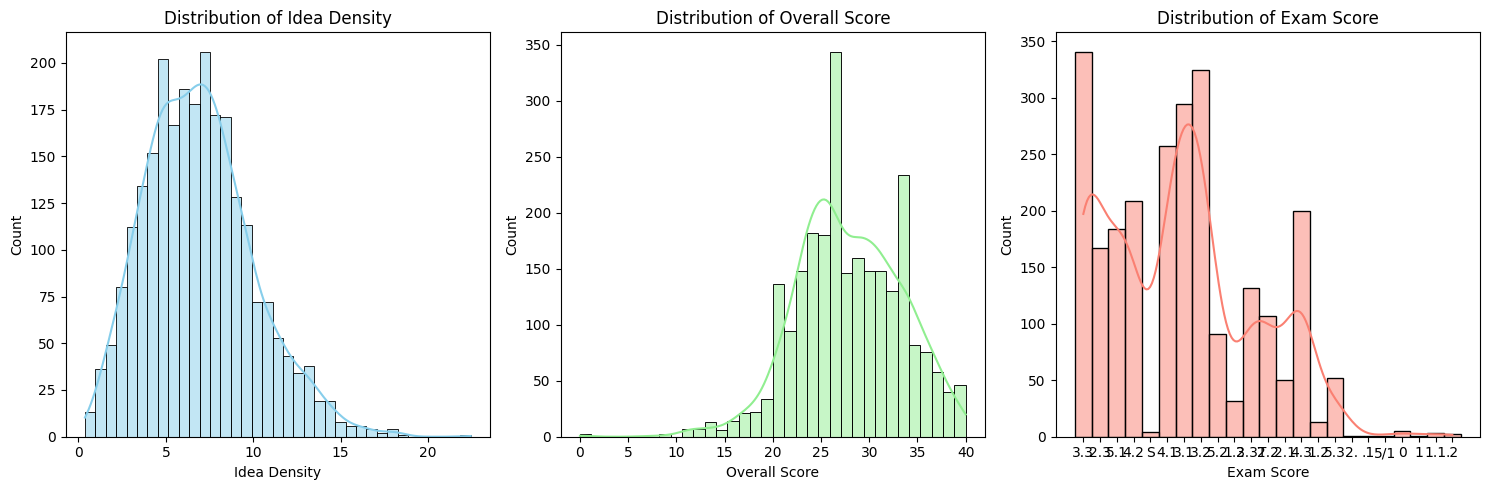

In [19]:
# Distribution of Key Variables

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Load the dataset
file_path = 'learners_data_with_idea_density.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

plt.figure(figsize=(15, 5))

# Idea Density Distribution
plt.subplot(1, 3, 1)
sns.histplot(data['Idea Density'], kde=True, color='skyblue')
plt.title('Distribution of Idea Density')

# Overall Score Distribution
plt.subplot(1, 3, 2)
sns.histplot(data['Overall Score'], kde=True, color='lightgreen')
plt.title('Distribution of Overall Score')

# Exam Score Distribution
plt.subplot(1, 3, 3)
sns.histplot(data['Exam Score'], kde=True, color='salmon')
plt.title('Distribution of Exam Score')

plt.tight_layout()
plt.show()


C:\Users\AMAN\AppData\Local\Temp\ipykernel_7552\2245504510.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Language', y='Idea Density', data=data, palette='Set2')


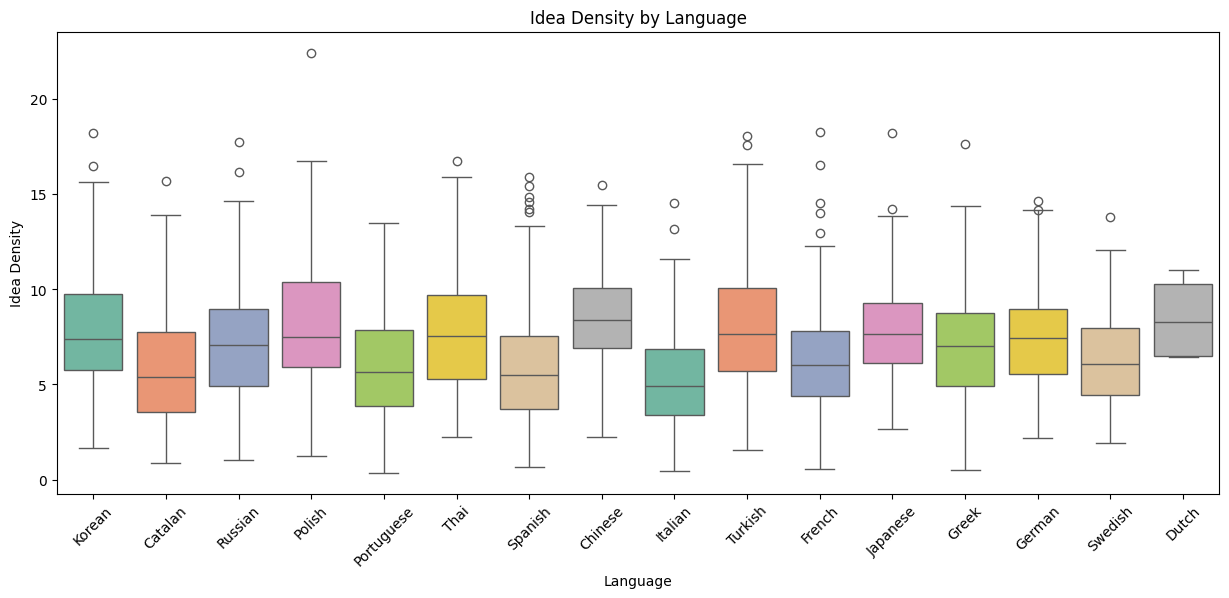

C:\Users\AMAN\AppData\Local\Temp\ipykernel_7552\2245504510.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Age', y='Idea Density', data=data, palette='Set3')


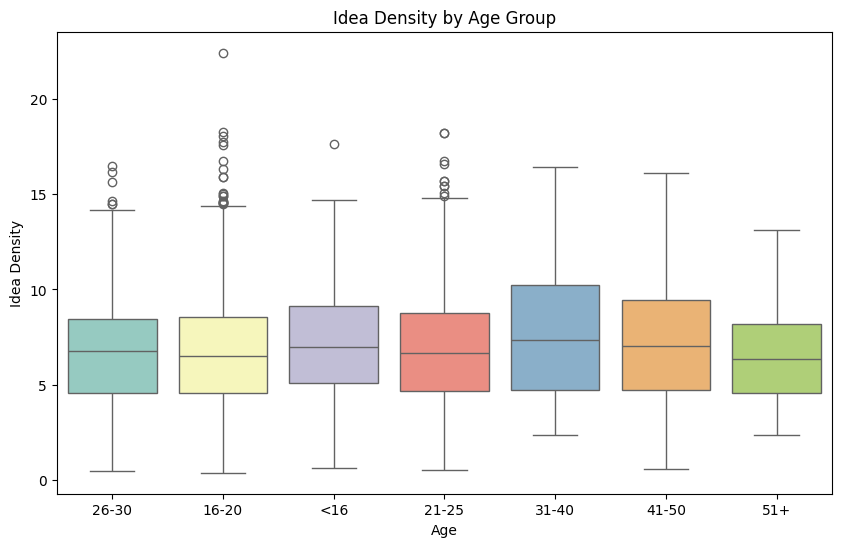

In [21]:
# Boxplot: Idea Density by Language
plt.figure(figsize=(15, 6))
sns.boxplot(x='Language', y='Idea Density', data=data, palette='Set2')
plt.xticks(rotation=45)
plt.title('Idea Density by Language')
plt.show()

# Boxplot: Idea Density by Age Group
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age', y='Idea Density', data=data, palette='Set3')
plt.title('Idea Density by Age Group')
plt.show()


                            OLS Regression Results                            
Dep. Variable:           Idea_Density   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     10.86
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           3.19e-49
Time:                        14:33:57   Log-Likelihood:                -6153.1
No. Observations:                2481   AIC:                         1.237e+04
Df Residuals:                    2449   BIC:                         1.256e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


<Figure size 1000x600 with 0 Axes>

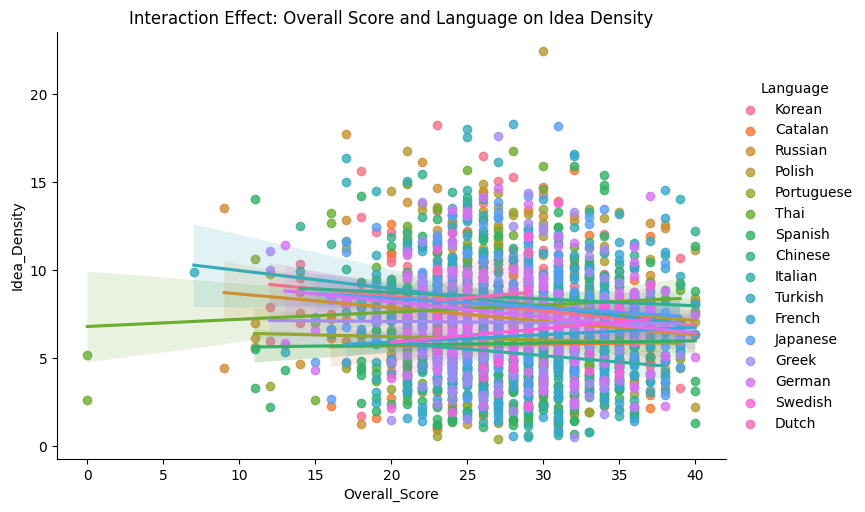

In [25]:
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# Rename columns to avoid spaces
data = data.rename(columns={
    'Idea Density': 'Idea_Density',
    'Overall Score': 'Overall_Score'
})

# Interaction model: Overall Score * Language
interaction_model = smf.ols('Idea_Density ~ Overall_Score * Language', data=data).fit()
print(interaction_model.summary())

# Visualization of interaction
plt.figure(figsize=(10, 6))
sns.lmplot(x='Overall_Score', y='Idea_Density', hue='Language', data=data, aspect=1.5)
plt.title('Interaction Effect: Overall Score and Language on Idea Density')
plt.show()

Column names: Index(['File Name', 'Sort Key', 'Language', 'Age', 'Overall_Score',
       'Question Number', 'Exam Score', 'Answer Text', 'Idea_Density'],
      dtype='object')


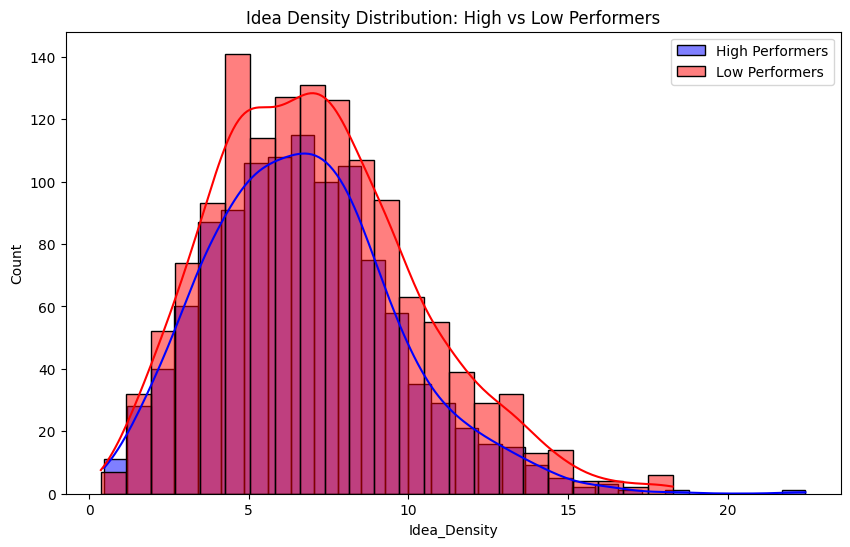

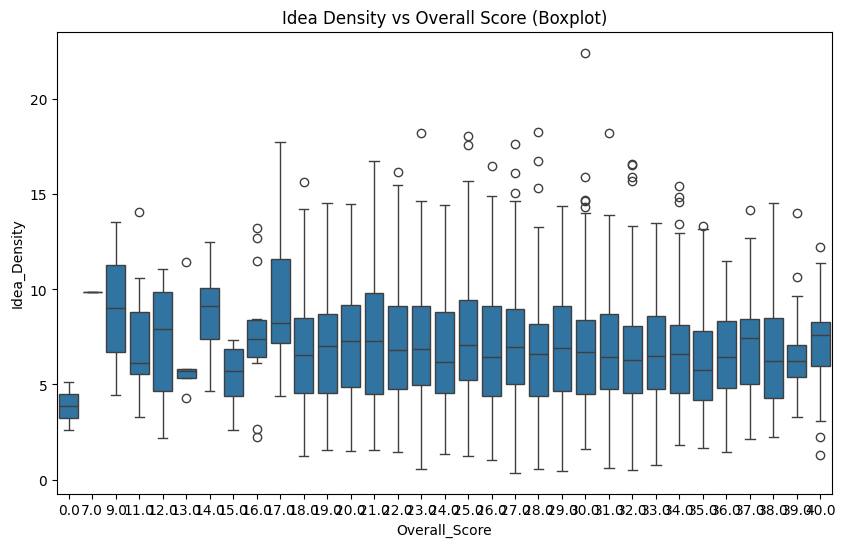

In [30]:
# First, let's print out the column names
print("Column names:", data.columns)

# Assuming the correct column name is 'overall_score' (adjust as needed)
score_column = 'Overall_Score'  # Change this to match your actual column name
density_column = 'Idea_Density'  # Change this to match your actual column name

# Create groups based on performance
high_performers = data[data[score_column] > data[score_column].median()]
low_performers = data[data[score_column] <= data[score_column].median()]

# Compare idea density distributions
plt.figure(figsize=(10, 6))
sns.histplot(high_performers[density_column], kde=True, color='blue', label='High Performers')
sns.histplot(low_performers[density_column], kde=True, color='red', label='Low Performers')
plt.legend()
plt.title('Idea Density Distribution: High vs Low Performers')
plt.show()

# Boxplot comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x=score_column, y=density_column, data=data)
plt.title('Idea Density vs Overall Score (Boxplot)')
plt.show()

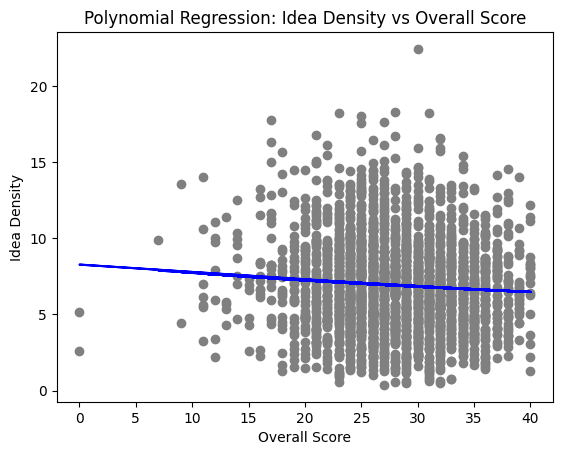

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

# Polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data[['Overall_Score']])

# Fit the model
poly_model = LinearRegression()
poly_model.fit(X_poly, data['Idea_Density'])

# Plotting results
plt.scatter(data['Overall_Score'], data['Idea_Density'], color='gray')
plt.plot(data['Overall_Score'], poly_model.predict(X_poly), color='blue')
plt.title('Polynomial Regression: Idea Density vs Overall Score')
plt.xlabel('Overall Score')
plt.ylabel('Idea Density')
plt.show()


In [36]:
def age_to_numeric(age_range):
    if isinstance(age_range, str):
        if age_range.startswith('<'):
            return int(age_range[1:]) - 1  # e.g., '<16' becomes 15
        elif age_range.endswith('+'):
            return int(age_range[:-1]) + 5  # e.g., '65+' becomes 70
        else:
            ages = age_range.split('-')
            return sum(map(int, ages)) / len(ages)
    return age_range

# Apply the function and print the result
data['Age_Numeric'] = data['Age'].apply(age_to_numeric)
print(data[['Age', 'Age_Numeric']].head(10))

     Age  Age_Numeric
0  26-30         28.0
1  26-30         28.0
2  16-20         18.0
3  16-20         18.0
4    <16         15.0
5    <16         15.0
6  16-20         18.0
7  16-20         18.0
8  16-20         18.0
9  16-20         18.0


In [38]:
data_clean = data.dropna()

In [39]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

C:\Users\AMAN\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


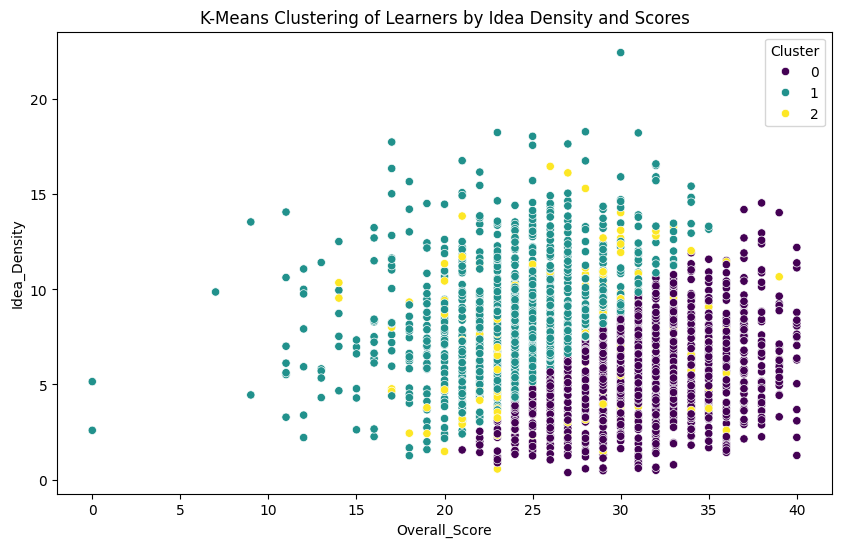

In [40]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant features for clustering
X = data[['Idea_Density', 'Overall_Score', 'Age_Numeric']]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualizing clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Overall_Score', y='Idea_Density', hue='Cluster', data=data, palette='viridis')
plt.title('K-Means Clustering of Learners by Idea Density and Scores')
plt.show()